In [30]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [17]:
# define a transformation class in order to apply some image transformation on the MNIST dataset
from torchvision import transforms

# define transformations
data_transform = transforms.Compose([
        transforms.ToTensor()])

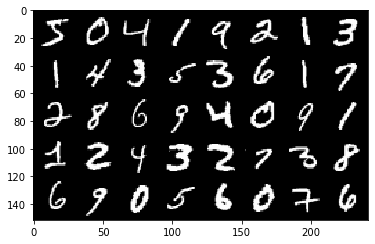

In [18]:
# load MNIST training dataset
from torchvision import datasets

# path to store data
path2data = './data'

# load training data
train_data = datasets.MNIST(path2data, train=True, download=True, transform=data_transform)


# extract the input data and target labels
x_train, y_train = train_data.data, train_data.targets

# load the MNIST test dataset
# load validation data without data transformation
val_data = datasets.MNIST(path2data, train=False, download=True)

# extract the data and targets
x_val, y_val = val_data.data, val_data.targets

# add a new dimension to the tensors to become B*C*H*W
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1) # add one dimension at 1 index

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# check a few sample images
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# Allows you to view the picture directly from the browser that ran notebook
%matplotlib inline

# define a helper function to display tensors as images
def show(img):
    # convert tensor to numpy array
    npimg = img.numpy()
    # convert to H*W*C shape from C*H*W
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# create a grid of images and display them
# make a grid of 40 images, 8 images per row
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2) # padding means edge pixel

# call helper function
show(x_grid)

Text(0.5, 1.0, 'transpose')

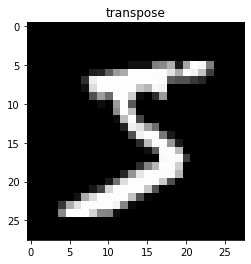

In [19]:
# check transpose
img = train_data[0][0]
img_np = img.numpy().squeeze(0)

plt.imshow(img_np,cmap='gray')
plt.title('transpose')

In [20]:
# create a PyTorch dataset by wrapping x_train and y_train
from torch.utils.data import TensorDataset

# wrap tensors into a dataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

In [21]:
# create two data loaders for the training and validaiton datasets
from torch.utils.data import DataLoader

# create a data loader from dataset
train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)

In [22]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # input, output, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()

In [23]:
# move the model to the CUDA device
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [24]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [25]:
from torch import nn
from torch import optim

# define the negative log-likelihood loss
loss_func = nn.NLLLoss(reduction='sum')

# define the Adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-4)

In [26]:
# define a helper function to compute the loss value per mini-batch
def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward() # compute gradient
        opt.step() # update parameters
        opt.zero_grad() # set gradients to zero
    return loss.item(), metric_b

# define a helper function to compute the accurary per mini-batch
def metrics_batch(target, output):
    # optain output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()

    return corrects

# define a helper fuction to compute the loss and metric values for a dataset
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        # obtain model output
        yb_h = model(xb)

        loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
        loss += loss_b
        if metric_b is not None:
            metric += metric_b

    loss /= len_data
    metric /= len_data
    return loss, metric

In [27]:
# define train_val function
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train() # convert to train mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        model.eval() # convert to evaluation mode
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        accuracy = 100 * val_metric
        print('epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(epoch, train_loss, val_loss, accuracy))

In [29]:
# train model for a few epochs
# call train_val function
num_epochs = 5
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

epoch: 0, train loss: 0.147811, val loss: 0.078294, accuracy: 97.60
epoch: 1, train loss: 0.047879, val loss: 0.068205, accuracy: 97.93
epoch: 2, train loss: 0.027303, val loss: 0.065415, accuracy: 98.33
epoch: 3, train loss: 0.019477, val loss: 0.078615, accuracy: 98.27
epoch: 4, train loss: 0.014917, val loss: 0.064568, accuracy: 98.60
epoch: 0, train loss: 0.012663, val loss: 0.052677, accuracy: 98.86
epoch: 1, train loss: 0.011341, val loss: 0.063735, accuracy: 98.77
epoch: 2, train loss: 0.010268, val loss: 0.059470, accuracy: 99.00
epoch: 3, train loss: 0.008763, val loss: 0.069187, accuracy: 98.80
epoch: 4, train loss: 0.008150, val loss: 0.053424, accuracy: 99.17
